# Predict Insurance Claim Denial

- We are interested in an analytic and/or predictive model to predict claims that would be denied with the following Denial.Reason.Code: F13, J8G, JO5, JB8, JE1, JC9, JF1, JF9, JG1, JPA and JES.
- Feel free to use any language (e.g. R, Python). Please send us the code and a brief write up of your findings (e.g. on the sensitivity and specificity of the algorithm).

# Import pandas, sklearn, numpy and matplotlib

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import sem
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import naive_bayes
from sklearn import ensemble
from sklearn import neighbors
from sklearn import metrics
from sklearn import learning_curve
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import kernel_approximation
from sklearn import feature_selection
from scipy.stats import randint as sp_randint
from IPython import embed
import seaborn
%matplotlib inline 

# Helper functions

- helper functions used to visualize data and plot error curves

In [96]:
# HELPER FUNCTION DEFINITIONS
def confusion_matrix(y_true, y_pred):
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
  plt.matshow(confusion_matrix)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.colorbar()
  plt.show()


def roc_curve(model, X_test, y_test):
  preds_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba)
  roc_auc = metrics.auc(fpr, tpr)
  plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
  plt.plot(fpr, tpr, 'k--', label='ROC (area = %0.2f)' % roc_auc, lw=2)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate=1-specificity')
  plt.ylabel('True Positive Rate/Recall/Sensitivity')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")


def precision_recall_curve(model, X_test, y_test):
  score = model.decision_function(X_test)
  precision, recall, _ = metrics.precision_recall_curve(y_test, score)
  plt.plot(recall, precision, label='Precision-Recall curve')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall/Sensitivity')
  plt.ylabel('Precision')
  plt.title('Precision-Recall curve')
  plt.legend(loc="lower right")


def learning_curves(X_train, y_train, model, scoring='accuracy', cv=5):
  plt.figure()
  plt.title("Learning curve")
  plt.xlabel("Number of training examples")
  plt.ylabel("scores")
  train_sizes, train_scores, test_scores = learning_curve.learning_curve(model, X_train, y_train, scoring=scoring, cv=cv, verbose=1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="r")
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
  plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="g")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
  plt.legend(loc="best")
  plt.autoscale(tight=True)
  plt.show()

    
def model_selection(X_train, X_test, y_train, y_test, parameters, clf, scoring=None, cv=3):
  clf_grid = grid_search.RandomizedSearchCV(clf, parameters, verbose=1, scoring=scoring, cv=cv, n_jobs=-1)
  # clf_grid = grid_search.GridSearch(clf, parameters, verbose=1, scoring=scoring, cv=cv, n_jobs=-1)
  clf_grid.fit(X_train, y_train)
  print "------------------------------------------------------------------------"
  print "best parameters:"
  print clf_grid.best_params_
  print "best score:"
  print clf_grid.best_score_
  print "------------------------------------------------------------------------"
  print("Best parameters set found on training set:")
  print(clf_grid.best_estimator_)
  print "------------------------------------------------------------------------"
  print("Grid scores on training set:")
  for params, mean_score, scores in clf_grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))
  print "------------------------------------------------------------------------"
  print("Detailed classification report for test:")
  y_true, y_pred = y_test, clf_grid.predict(X_test)
  print(metrics.classification_report(y_true, y_pred))
  return clf_grid


def feature_importance(model, top=25):
  feature_importance = model.feature_importances_
  # Normalize The Features
  feature_importance = 100.0 * (feature_importance / feature_importance.max())
  sorted_idx = np.argsort(feature_importance)
  pos = np.arange(sorted_idx.shape[0]) + .5
  # plt.figure(figsize=(16, 12))
  plt.barh(pos[-top:], feature_importance[sorted_idx[-top:]], align='center', color='#7A68A6')
  # plt.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
  plt.yticks(pos[-top:], sorted_idx[-top:])
  plt.xlabel('Relative Importance')
  plt.ylabel('Feature Column Number')
  plt.title('Feature Importance')
  plt.show()

# Data import and transform

- Replace empty cells by NaN code, drop duplicates and keep only rows with actual denial code

In [139]:
# READ DATA replace empty cells by nan
df = pd.read_csv("claim.sample.csv", index_col=0, na_values=[" "], low_memory=False)

In [140]:
df = df.drop_duplicates()
# keep only rows where we actually have a denial code
df = df[df['Denial.Reason.Code'].notnull()]
df.shape

(146529, 28)

- 146529 total cases left and 28 features

# Feature Engineering

- we separate features by type
- encode categorical features with type "category"
- code denial reason code into binary variable YES (denied) and NO (approved)
- check the number of categories for each category/feature

In [141]:
# Separate Features by type
categorical = [
    u'Claim.Line.Number', u'Provider.ID',
    u'Line.Of.Business.ID', u'Revenue.Code', u'Service.Code',
    u'Place.Of.Service.Code',
    u'Price.Index',
    u'In.Out.Of.Network', u'Reference.Index', u'Pricing.Index',
    u'Capitation.Index',
    u'Claim.Type', u'Claim.Subscriber.Type',
    u'Claim.Pre.Prince.Index', u'Claim.Current.Status', u'Network.ID',
    u'Agreement.ID']
indices = [u'Claim.Number', u'Group.Index', u'Subscriber.Index', u'Subgroup.Index']
continuous = [u'Claim.Charge.Amount', u'Subscriber.Payment.Amount', u'Provider.Payment.Amount']
medical_idx = [u'Procedure.Code', u'Diagnosis.Code']
denial = [u'Denial.Reason.Code']
user_id = [u'Member.ID']

categorical_2 = [
    u'Claim.Line.Number', u'Provider.ID',
    u'Line.Of.Business.ID', u'Revenue.Code', u'Service.Code',
    u'In.Out.Of.Network', u'Reference.Index', u'Pricing.Index',
    u'Claim.Type', u'Claim.Subscriber.Type',
    u'Claim.Current.Status', u'Network.ID',
    u'Agreement.ID']

len(categorical)+len(indices)+len(continuous)+len(medical_idx)+len(denial)+len(user_id)

28

In [157]:
# encode features into factor variables and check number of category per feature
for col in df[categorical]:
    df[col] = df[col].astype('category')
    print "---- "+ col
    print df[col].describe()

for col in df[medical_idx]:
    df[col] = df[col].astype('category')
    print "---- "+ col
    print df[col].describe()

for col in df[denial]:
    df[col] = df[col].astype('category')

for col in df[indices]:
    df[col] = df[col].astype('category')
    print "---- "+ col
    print df[col].describe()

df['Member.ID'] = df['Member.ID'].astype('category')
print "---- Member.ID"
df['Member.ID'].describe()

---- Claim.Line.Number
count     146529
unique       135
top            1
freq       30477
Name: Claim.Line.Number, dtype: int64
---- Provider.ID
count           146529
unique              26
top       FA0001411001
freq             42856
Name: Provider.ID, dtype: object
---- Line.Of.Business.ID
count     144700
unique         5
top            1
freq       72859
Name: Line.Of.Business.ID, dtype: float64
---- Revenue.Code
count     146473
unique       160
top         0301
freq       16764
Name: Revenue.Code, dtype: object
---- Service.Code
count     146529
unique       112
top         LA7O
freq       32571
Name: Service.Code, dtype: object
---- Place.Of.Service.Code
count     56
unique     2
top       11
freq      43
Name: Place.Of.Service.Code, dtype: float64
---- Price.Index
count     127502
unique         2
top            A
freq      124635
Name: Price.Index, dtype: object
---- In.Out.Of.Network
count     143781
unique         2
top            I
freq      141717
Name: In.Out.Of.Networ

count       146529
unique       11799
top       21880031
freq           750
Name: Member.ID, dtype: int64

In [159]:
# transform denial target codes to binary
denial = ["F13", "J8G", "JO5", "JB8", "JE1", "JC9", "JF1", "JF9", "JG1", "JPA", "JES"]
target = []
for row in df['Denial.Reason.Code']:
    if row in denial:
        target.append('YES')
    else:
        target.append('NO')
df['target'] = target

# Descriptive Analysis

A pie plot of the data shows that the dataset is highly unbalanced with **1.3% of denial**

NO     144558
YES      1971
Name: target, dtype: int64
% of denial:  0.0134512622075


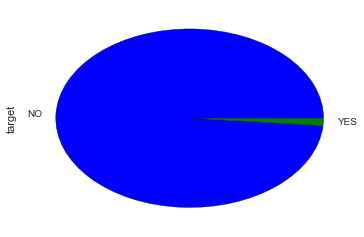

In [160]:
print df['target'].value_counts()
df['target'].value_counts().plot(kind='pie')
print "% of denial: ", 1971./(1971+144558)

# Multicollinearity

In [9]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
plsca = PLSCanonical(n_components=2)
# plsca.fit(X, y)
# X_train_r, Y_train_r = plsca.transform(X, y)

# Correlation of Continuous Features

- The continuous features claim.charge.amount and provider.payment.amount are correlated (r~0.54), which makes sense

                           Claim.Charge.Amount  Subscriber.Payment.Amount  \
Claim.Charge.Amount                   1.000000                   0.006007   
Subscriber.Payment.Amount             0.006007                   1.000000   
Provider.Payment.Amount               0.536622                   0.001362   

                           Provider.Payment.Amount  
Claim.Charge.Amount                       0.536622  
Subscriber.Payment.Amount                 0.001362  
Provider.Payment.Amount                   1.000000  


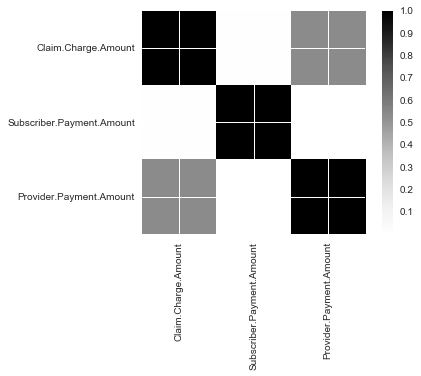

In [68]:
plt.imshow(abs(df[continuous].corr()) , interpolation='nearest')
ax = plt.axes()
plt.colorbar()
#ax.set_xticks(range(len(df.corr().columns)))
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df[continuous].columns, rotation=90)
ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df[continuous].columns)
plt.plot()
print abs(df[continuous].corr())

# Percentage of null values per type of feature

- place.of.service.code feature has consistently 99% NaN accross classes so we can get rid of it
- price.index, capitation.index, claim.pre.prince.index have also >15% NaN

In [122]:
denials = df[df.target=='YES']
approvals = df[df.target=='NO']

In [125]:
X = denials[categorical]
print "---- denials"
print 1-(X.count()/X.shape[0])
X = approvals[categorical]
print "---- approvals"
print 1-(X.count()/X.shape[0])

---- denials
Claim.Line.Number         0.000000
Provider.ID               0.000000
Line.Of.Business.ID       0.000000
Revenue.Code              0.010147
Service.Code              0.000000
Place.Of.Service.Code     0.989853
Price.Index               0.257737
In.Out.Of.Network         0.000000
Reference.Index           0.000000
Pricing.Index             0.000000
Capitation.Index          0.174531
Claim.Type                0.000000
Claim.Subscriber.Type     0.000000
Claim.Pre.Prince.Index    0.825469
Claim.Current.Status      0.000000
Network.ID                0.021309
Agreement.ID              0.000000
dtype: float64
---- approvals
Claim.Line.Number         0.000000
Provider.ID               0.000000
Line.Of.Business.ID       0.012652
Revenue.Code              0.000249
Service.Code              0.000000
Place.Of.Service.Code     0.999751
Price.Index               0.128108
In.Out.Of.Network         0.019010
Reference.Index           0.000000
Pricing.Index             0.000000
Capitation.I

In [126]:
X = denials[medical_idx]
print "---- denials"
print 1-(X.count()/X.shape[0])
X = approvals[medical_idx]
print "---- approvals"
print 1-(X.count()/X.shape[0])

---- denials
Procedure.Code    0.335363
Diagnosis.Code    0.000000
dtype: float64
---- approvals
Procedure.Code    0.191563
Diagnosis.Code    0.000000
dtype: float64


# Encode features and target

In [162]:
# X = df[categorical+indices+medical_idx+user_id+continuous]
# X = df[categorical+medical_idx+user_id+continuous]
X = df[categorical+medical_idx+continuous]
print X.shape

# Encode features
feature_le = preprocessing.LabelEncoder()
X = X.apply(feature_le.fit_transform)

ohe = preprocessing.OneHotEncoder()
ohe.fit(X)
X = ohe.transform(X)
print X.shape
# Encode binary target
target_le = preprocessing.LabelEncoder()
target_le.fit(df.target)
print target_le.classes_
y = target_le.transform(target)

(146529, 22)
(146529, 193504)
['NO' 'YES']


# Correlations

In [12]:
# corr_ = np.corrcoef(X.todense())

# Split data into train and test sets

In [163]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.20)

# Models

In [164]:
models = {}
models['lr'] = linear_model.LogisticRegression(n_jobs=-1, class_weight='balanced')
# models['pac'] = linear_model.PassiveAggressiveClassifier(n_jobs=-1)
# models['sgdc'] = linear_model.SGDClassifier(n_jobs=-1) #, class_weight='balanced')
# # models['ridge'] = linear_model.RidgeClassifier(class_weight='balanced')
# # models['svm'] = svm.SVC() # kernel='rbf', probability=True, class_weight='balanced')
# # models['nb'] = naive_bayes.GaussianNB()
# # models['gbc'] = ensemble.GradientBoostingClassifier()
models['rfc'] = ensemble.RandomForestClassifier(n_jobs=-1, class_weight='balanced')
# models['etc'] = ensemble.ExtraTreesClassifier(n_jobs=-1, class_weight='balanced')
# models['knc'] = neighbors.KNeighborsClassifier(n_jobs=-1)

# Cross validated metrics

In [165]:
for algo in models:
    model = models[algo]
    cv = cross_validation.StratifiedKFold(y_train, n_folds=3, shuffle=True)
    # scoring: 'accuracy, f1, recall, roc_auc'
    # scores = cross_validation.cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    scores = cross_validation.cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    print "---"+algo
    print scores.mean() # , sem(scores)

---rfc
0.480487574188
---lr
0.664652589315


# Classification report on test set

In [166]:
# When making predictions, retrain the model on the whole training set
for algo in models:
  print "----"+ algo
  model = models[algo]
  if algo == 'gbc':
    model.fit(X_train.todense(), y_train)
  else:
    model.fit(X_train, y_train)
  preds = model.predict(X_test)
  print metrics.classification_report(y_test, preds)

----rfc
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     28921
          1       0.81      0.42      0.55       385

avg / total       0.99      0.99      0.99     29306

----lr
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     28921
          1       0.51      0.92      0.66       385

avg / total       0.99      0.99      0.99     29306



# Learning Curve

[learning_curve] Training set sizes: [ 7814 25398 42981 60564 78148]


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished


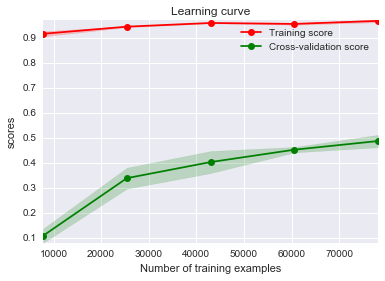

In [167]:
learning_curves(X_train, y_train, models['rfc'], scoring='f1', cv=3)

[learning_curve] Training set sizes: [ 7814 25398 42981 60564 78148]


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.2s finished


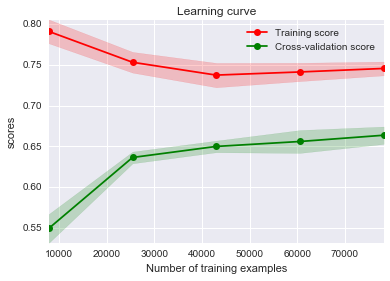

In [168]:
learning_curves(X_train, y_train, models['lr'], scoring='f1', cv=3)

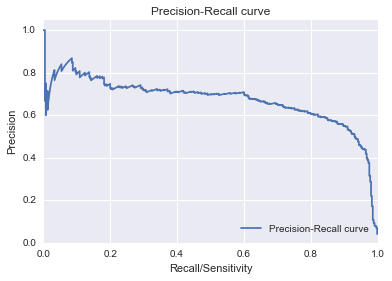

In [169]:
precision_recall_curve(models['lr'], X_test, y_test)

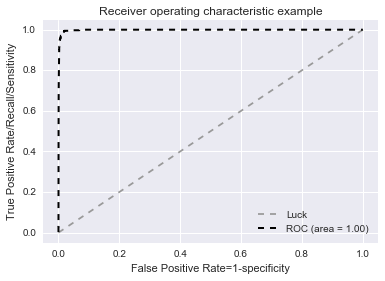

In [98]:
roc_curve(models['lr'], X_test, y_test)

# Feature selection

In [26]:
# rfecv = feature_selection.RFECV(
#     estimator=models['lr'],
#     step=1, cv=cross_validation.StratifiedKFold(y_train, 2),
#     scoring='f1')
# rfecv.fit(X_train, y_train)
rfe = feature_selection.RFE(estimator = models['lr'], step =10)
rfe.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Hyperparameter CV optimization 

In [ ]:
# do hyperparameter optimization on cross validation set
#parameters = [{'n_estimators': [40, 50], 'max_features': ['auto', 'sqrt']}]
# parameters = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"],
# #               'n_estimators': [20, 40, 80, 160],
# #               'max_features': ['auto', 'sqrt']
#              }

model = model_selection(X_train,X_test,y_train,y_test,parameters,models['rfc'], scoring='f1')